In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skl
from itertools import chain
from random import sample

import pydicom


# Data Cleaning - Prepare Curated dataset 
1. Find and remove duplicate records in the provided dataset - No duplicate records present in the dataset
2. Identify NAN records or columns - Identified the last column with only NAN records. Hence dropped the column 
3. Split the data as per the analysis requirements (if required)- Finding Labels column splitted according to unique Disease Labels and given binary values 
4. Look for errorenous/ outlier data in columns - Patient Age has outliers (Age > 100 ranging till maximum of 414). Hence, filtering out the outliers' records from the dataset (16 rows are removed)

In [7]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head(1000)
analysis_df = all_xray_df.drop_duplicates()

In [8]:
analysis_df.isnull().sum()
analysis_df.columns[[0,1,2,3,4,5,6]]
analysis_df[analysis_df.columns[-1]].unique().tolist()
analysis_df = analysis_df.dropna(axis=1,how='all')
analysis_df.isna().any()

Image Index                    False
Finding Labels                 False
Follow-up #                    False
Patient ID                     False
Patient Age                    False
Patient Gender                 False
View Position                  False
OriginalImage[Width            False
Height]                        False
OriginalImagePixelSpacing[x    False
y]                             False
dtype: bool

In [9]:
all_labels = np.unique(list(chain(*analysis_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        analysis_df[c_label] = analysis_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
analysis_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
56494,00014052_007.png,No Finding,7,14052,72,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
84850,00020908_003.png,Infiltration,3,20908,52,M,PA,2490,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
609,00000149_007.png,Fibrosis|Infiltration,7,149,71,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
analysis_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.103095,0.024759,0.041625,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.304084,0.155391,0.199732,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
age_lst =analysis_df['Patient Age'].unique().tolist()
lst = age_lst.sort()
print(age_lst)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 148, 149, 150, 151, 152, 153, 154, 155, 411, 412, 413, 414]


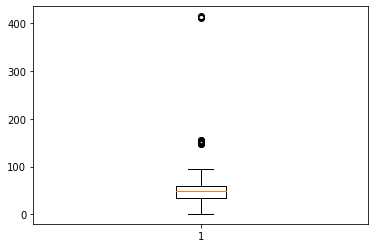

In [12]:
plt.boxplot(analysis_df['Patient Age'])
plt.show()

In [13]:
index = analysis_df[(analysis_df['Patient Age'] >= 100)|(analysis_df['Patient Age'] <= 0)].index
analysis_df = analysis_df.drop(index)

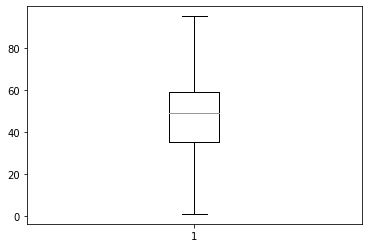

In [14]:
plt.boxplot(analysis_df['Patient Age'])
plt.show()

In [15]:
analysis_df.count()

Image Index                    112104
Finding Labels                 112104
Follow-up #                    112104
Patient ID                     112104
Patient Age                    112104
Patient Gender                 112104
View Position                  112104
OriginalImage[Width            112104
Height]                        112104
OriginalImagePixelSpacing[x    112104
y]                             112104
Atelectasis                    112104
Cardiomegaly                   112104
Consolidation                  112104
Edema                          112104
Effusion                       112104
Emphysema                      112104
Fibrosis                       112104
Hernia                         112104
Infiltration                   112104
Mass                           112104
No Finding                     112104
Nodule                         112104
Pleural_Thickening             112104
Pneumonia                      112104
Pneumothorax                   112104
dtype: int64

# Demographics Data Analysis 
1. Age Distribution - Highly affected age group ranges between 45 and 60
2. Gender Distribution - Overall, male population is highly affected than female population
3. Any significant analysis on columns - View Position & Follow-up
4. Which disease labels has more counts - where does our candidate (Pneumonia) rank in the list? 

[Text(0.5, 0, 'Disease Labels')]

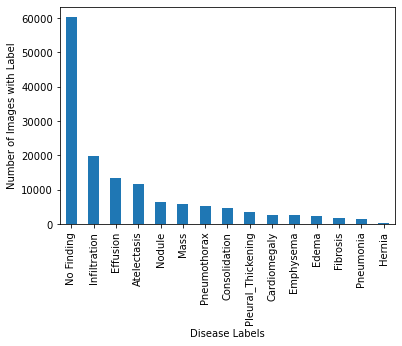

In [16]:
# the relative frequencies of each disease in my dataset;
# It looks like 'No Finding' is the most common occurrence. 
# 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image
ax = analysis_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
ax.set(xlabel = 'Disease Labels')

# Conclusion
Amongst all the 15 unique disease labels, 'No Finding' label had the maximum number of records in the dataset. 'No Finding' labels does not imply any disease name in particular. Although the label says 'No finding' based on NLP finding, it can contain useful metadata information that could possibly conclude for diagnosis of any particular chest related ailments. Hence, these set of datasets can't be excluded for training & validation datasets.

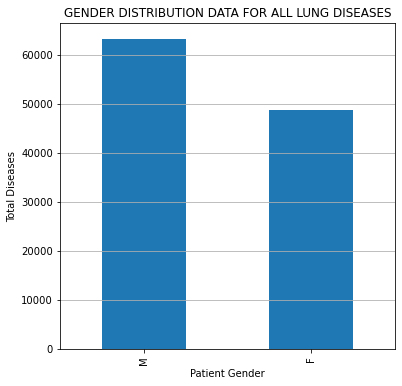

In [17]:
plt.figure(figsize=(6,6))
analysis_df['Patient Gender'].value_counts().plot(kind = 'bar')
plt.xlabel('Patient Gender')
plt.ylabel('Total Diseases')
plt.title('GENDER DISTRIBUTION DATA FOR ALL LUNG DISEASES')
plt.grid(axis='y')

# Conclusion
Male Population were highly infected with all the disease labels than Female population based on the analysis of the given NIH dataset

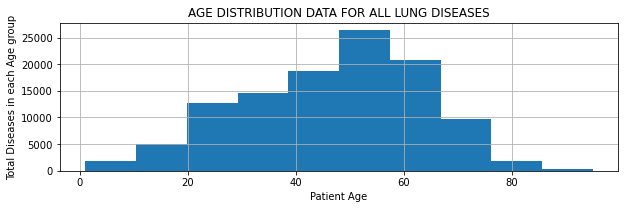

In [18]:
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.hist(analysis_df['Patient Age'])
plt.xlabel('Patient Age')
plt.ylabel('Total Diseases in each Age group')
plt.title('AGE DISTRIBUTION DATA FOR ALL LUNG DISEASES')
plt.grid()

# Conclusion
Age is normally distributed by looking at the above graph.
Note: Removed 16 records containing Outliers (i.e.,) Age greater than 100

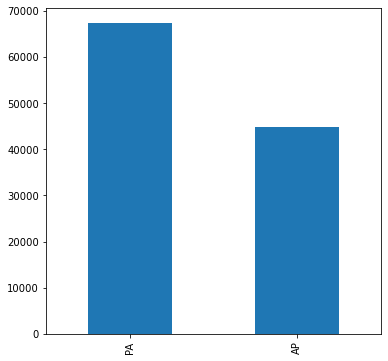

In [19]:
plt.figure(figsize=(6,6))
analysis_df['View Position'].value_counts().plot(kind = 'bar')

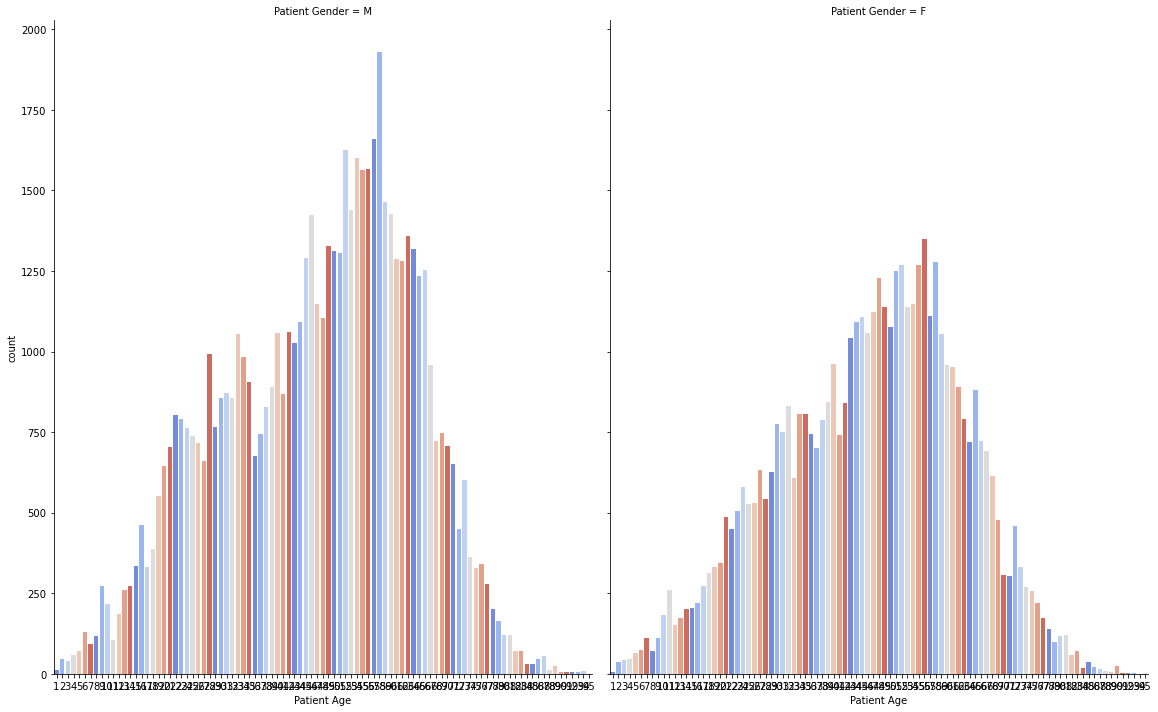

In [20]:
age_gender_distribution = sns.catplot(x='Patient Age',col='Patient Gender',data = analysis_df,kind='count',height=10,aspect=0.8,palette = sns.color_palette ('coolwarm', n_colors=7))

In [21]:
analysis_df[all_labels].corr()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Atelectasis,1.000000,0.015817,0.108945,-0.003379,0.172462,0.032598,0.011128,0.010830,0.093157,0.018995,-0.366142,-0.007972,0.025221,0.029948,0.031437
Cardiomegaly,0.015817,1.000000,0.015355,0.028331,0.130096,-0.007093,0.004834,0.001761,0.014191,-0.010670,-0.172081,-0.012128,0.009126,0.002859,-0.022249
Consolidation,0.108945,0.015355,1.000000,0.020835,0.101130,-0.000526,0.003233,-0.005414,0.045931,0.074610,-0.225077,0.031812,0.028742,0.025257,0.000487
Edema,-0.003379,0.028331,0.020835,1.000000,0.062127,-0.009200,-0.013241,-0.002325,0.094265,0.002939,-0.156364,0.000271,-0.002018,0.174110,-0.022479
Effusion,0.172462,0.130096,0.101130,0.062127,1.000000,0.011195,-0.002779,-0.003658,0.118164,0.070770,-0.396483,0.019109,0.072037,0.024112,0.047587
Emphysema,0.032598,-0.007093,-0.000526,-0.009200,0.011195,1.000000,-0.000910,-0.001466,0.000406,0.023232,-0.163630,-0.007067,0.026416,-0.004880,0.178194
Fibrosis,0.011128,0.004834,0.003233,-0.013241,-0.002779,-0.000910,1.000000,0.007477,0.008796,0.009972,-0.133444,0.022474,0.053590,-0.006862,0.000095
Hernia,0.010830,0.001761,-0.005414,-0.002325,-0.003658,-0.001466,0.007477,1.000000,-0.003780,0.011934,-0.048644,-0.002424,0.001331,0.000185,-0.001621
Infiltration,0.093157,0.014191,0.045931,0.094265,0.118164,0.000406,0.008796,-0.003780,1.000000,0.013898,-0.501559,0.042754,0.020411,0.073088,0.000597
Mass,0.018995,-0.010670,0.074610,0.002939,0.070770,0.023232,0.009972,0.011934,0.013898,1.000000,-0.251767,0.101300,0.065206,-0.000977,0.029980


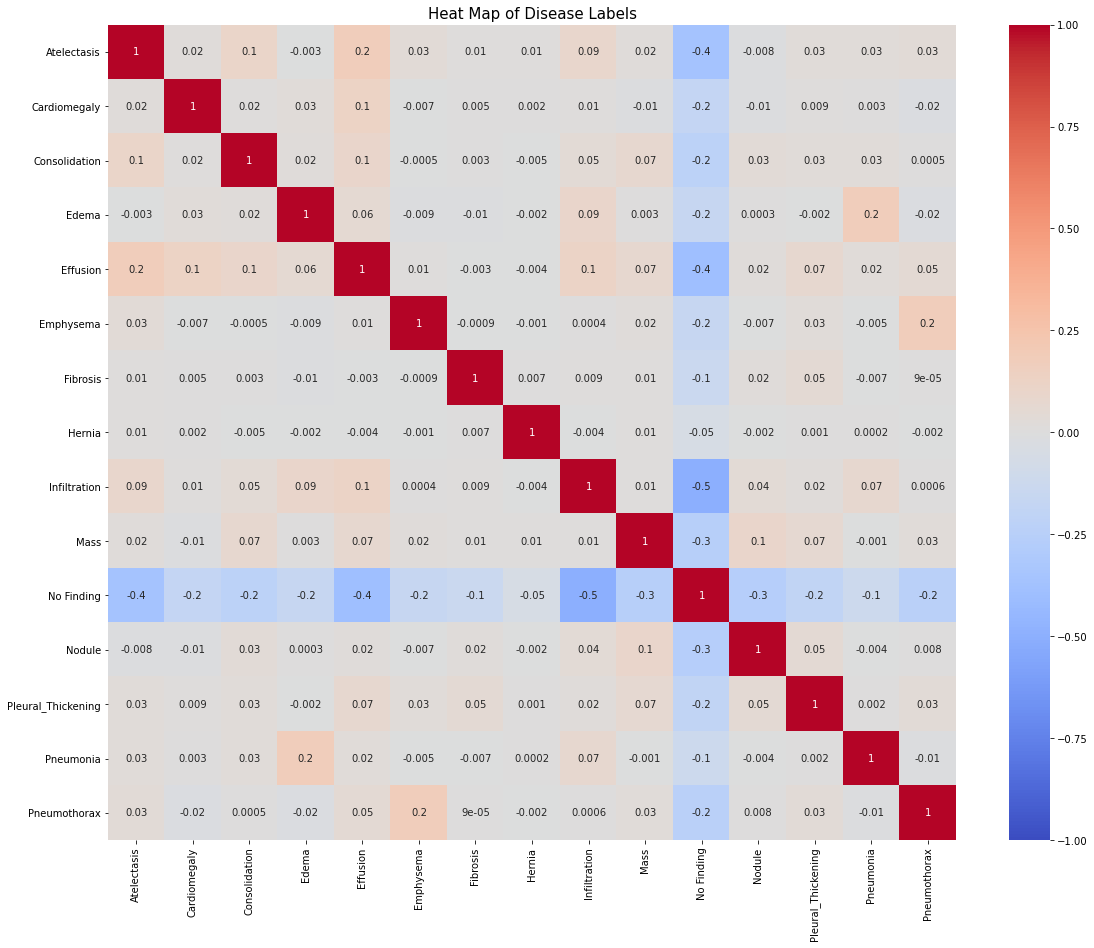

In [22]:
f = plt.figure(figsize = (19, 15))
plt.title('Heat Map of Disease Labels', fontsize = 15)
sns.heatmap(analysis_df[all_labels].corr(),annot=True,fmt='.1g',vmin=-1, vmax=1, center= 0,cmap= 'coolwarm',cbar_kws= {'orientation': 'vertical'} )

# Conclusion

Based on the Correlation Matrix shown above, it can be seen that the diseases that are closely occurring to Pneumonia are Edema and Infiltration with 20% and 7% occurence rates respectively.

# Demographics Data Analysis - Pneumonia Specific
1. Age Distribution - Highly affected age group ranges between 45 and 60
2. Gender Distribution - Overall, male population is highly affected than female population
3. Any significant analysis on columns - View Position & Follow-up
4. Which disease labels has more counts - where does our candidate (Pneumonia) rank in the list? 

In [23]:
analysis_df[all_labels].sum()

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0
dtype: float64

In [24]:
analysis_df[analysis_df.Pneumonia==1]['Finding Labels'].value_counts().sum()

1430

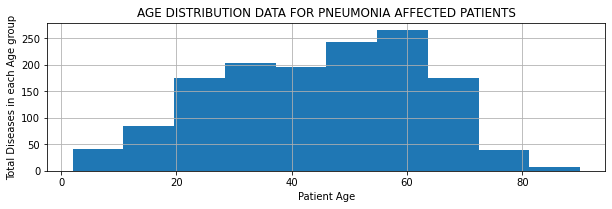

In [25]:
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.hist(analysis_df[analysis_df.Pneumonia==1]['Patient Age'])
plt.xlabel('Patient Age')
plt.ylabel('Total Diseases in each Age group')
plt.title('AGE DISTRIBUTION DATA FOR PNEUMONIA AFFECTED PATIENTS')
plt.grid()

# Conclusion
Age is normally distributed by looking at the above graph.

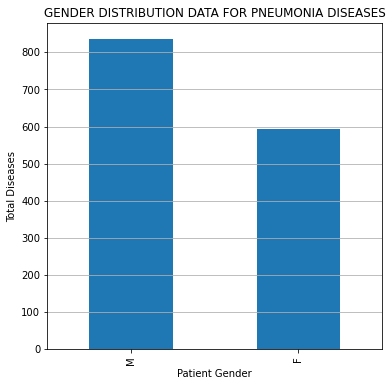

In [26]:
plt.figure(figsize=(6,6))
analysis_df[analysis_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind = 'bar')
plt.xlabel('Patient Gender')
plt.ylabel('Total Diseases')
plt.title('GENDER DISTRIBUTION DATA FOR PNEUMONIA DISEASES')
plt.grid(axis='y')

# Conclusion
Male Population were highly infected with Pneuomia than Female population based on the analysis of the given NIH dataset

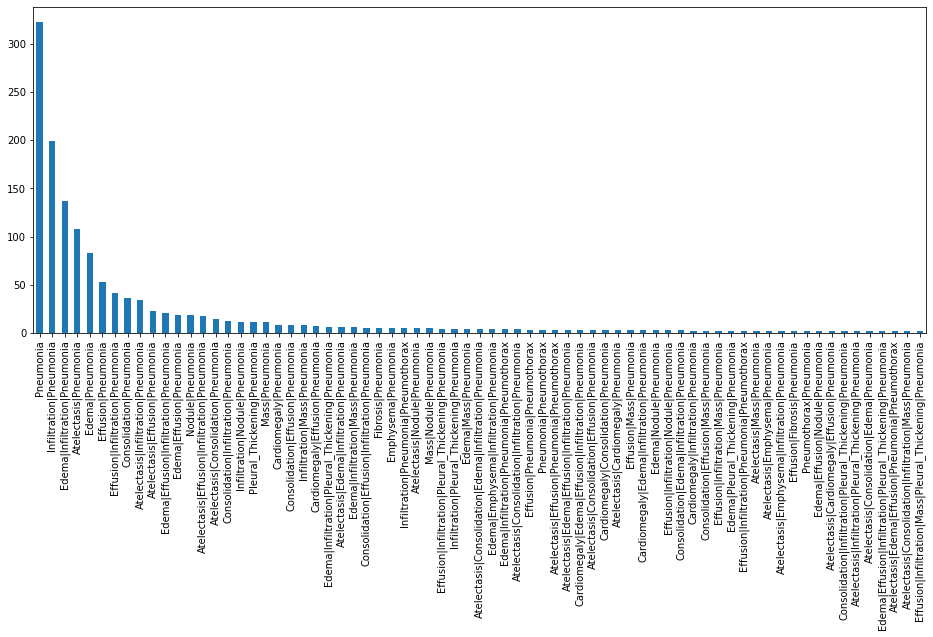

In [27]:
plt.figure(figsize=(16,6))
analysis_df[analysis_df.Pneumonia==1]['Finding Labels'].value_counts()[0:71].sort_values(ascending=False).plot(kind='bar')

# Conclusion

As concluded in the Correlation Matrix Conclusion section, with the bar plot, it can be seen that the diseases that are closely occurring to Pneumonia are Edema and Infiltration

# IMAGE PIXEL DATA ANALYSIS
1. Read the test dicom images using pydicom library and retreive the metadata to show how it looks like 

In [29]:
mydicoms = glob("*.dcm")

print(mydicoms)

['test5.dcm', 'test4.dcm', 'test6.dcm', 'test2.dcm', 'test3.dcm', 'test1.dcm']


In [30]:
dcm1 = pydicom.dcmread(mydicoms[0])

In [31]:
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [105]:
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)


[['2', 81, 'M', 'CT', 'No Finding', 1024, 1024], ['2', 81, 'M', 'DX', 'No Finding', 1024, 1024], ['2', 81, 'M', 'DX', 'No Finding', 1024, 1024], ['1', 58, 'M', 'DX', 'Cardiomegaly', 1024, 1024], ['61', 77, 'M', 'DX', 'Effusion', 1024, 1024], ['2', 81, 'M', 'DX', 'No Finding', 1024, 1024]]


In [106]:
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [107]:
mydata

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,2,81,M,CT,No Finding,1024,1024
1,2,81,M,DX,No Finding,1024,1024
2,2,81,M,DX,No Finding,1024,1024
3,1,58,M,DX,Cardiomegaly,1024,1024
4,61,77,M,DX,Effusion,1024,1024
5,2,81,M,DX,No Finding,1024,1024


In [120]:
path = "/data/images_002/images"
if os.path.exists(path):
    print(os.listdir(path))

['FAQ_CHESTXRAY.pdf', 'ARXIV_V5_CHESTXRAY.pdf', 'images_009', 'images_011', 'images_003', 'images_004', 'README_CHESTXRAY.pdf', 'images_012', 'images_007', 'images_005', 'train_val_list.txt', 'BBox_List_2017.csv', 'images_001', 'images_008', 'LOG_CHESTXRAY.pdf', 'images_006', 'test_list.txt', 'images_002', 'images_010', 'Data_Entry_2017.csv']


In [124]:


img_analysis_df = analysis_df.copy()

In [174]:
analysis_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


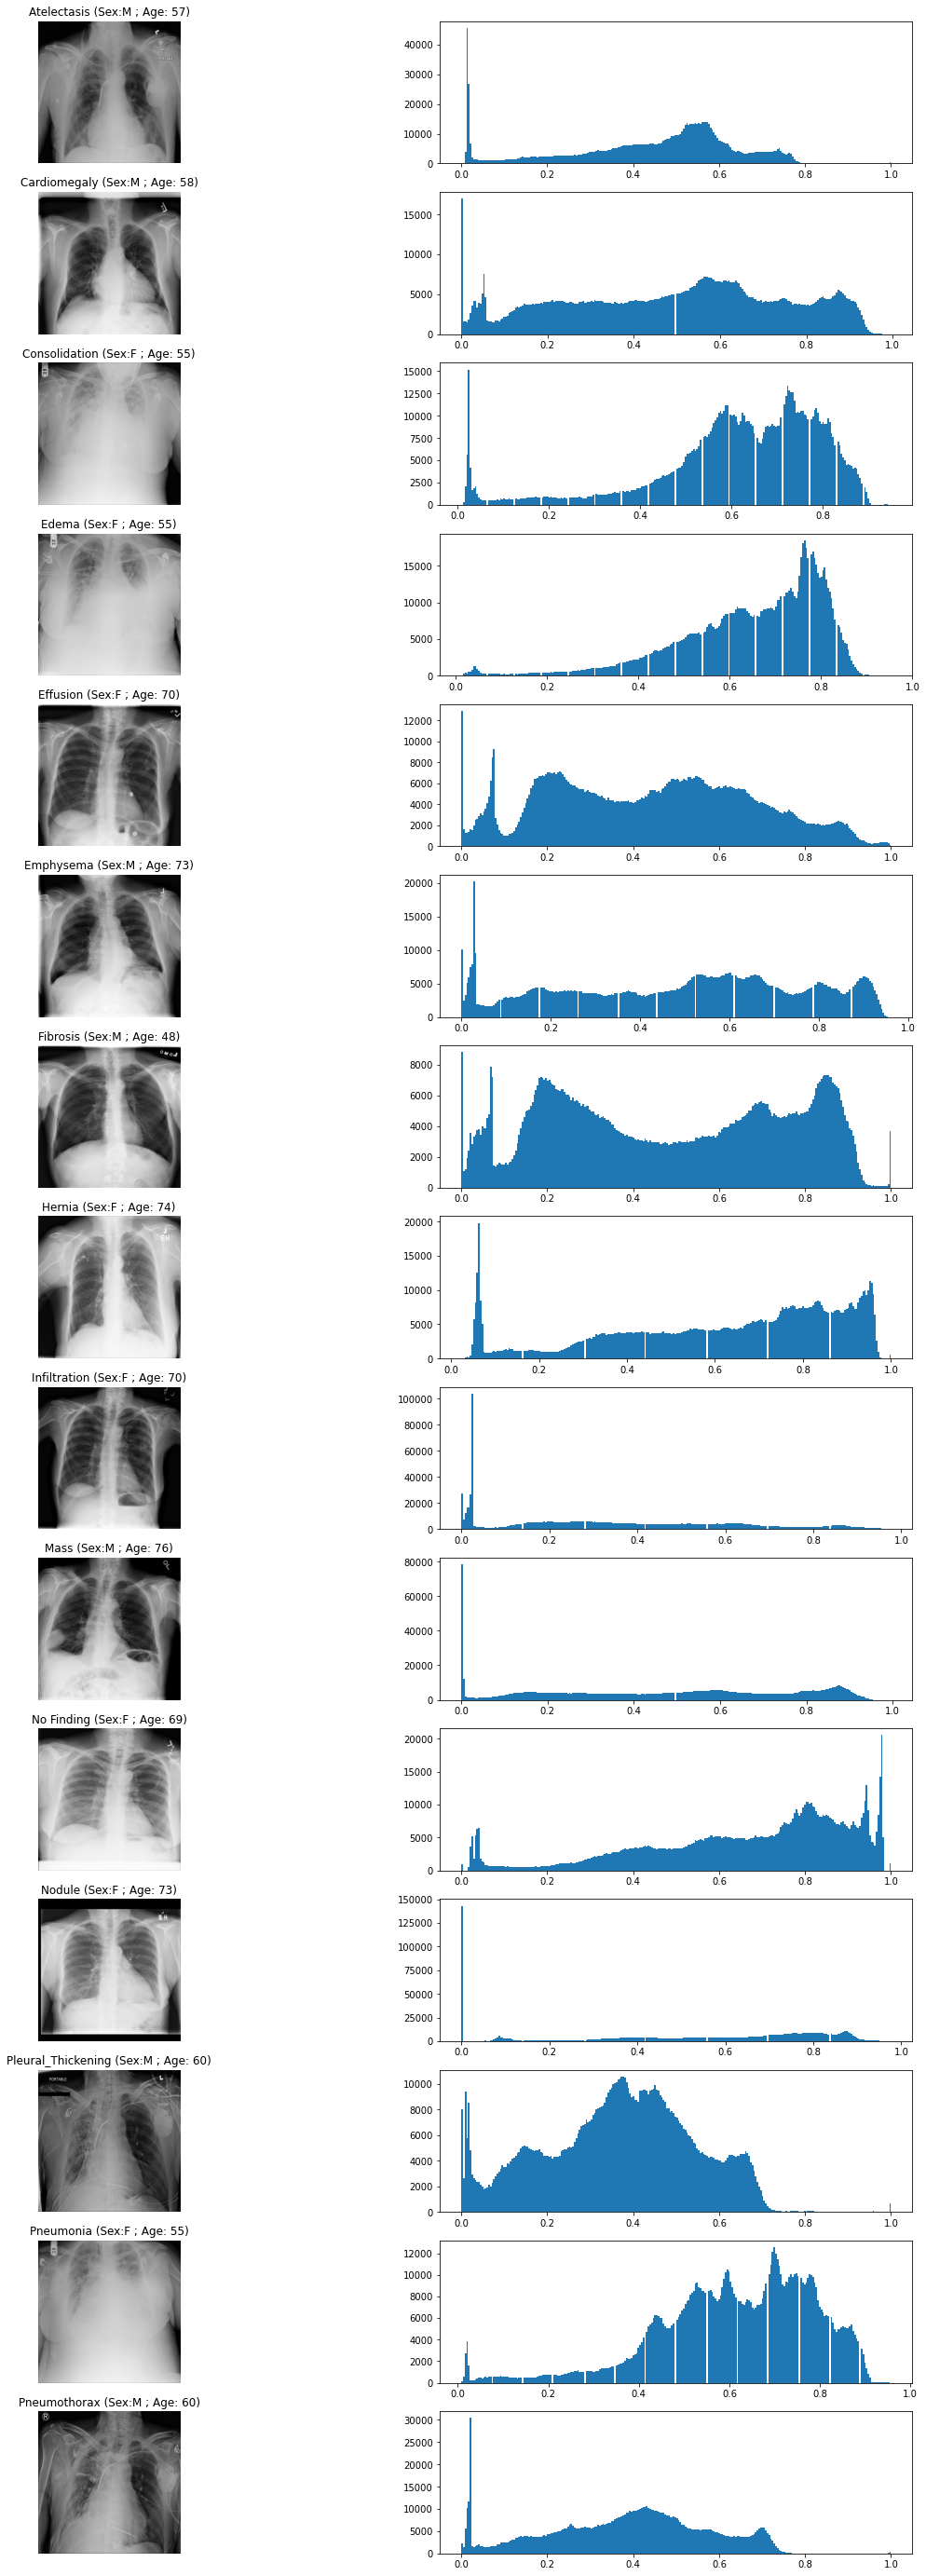

In [181]:
fig, ax = plt.subplots(len(all_labels), 2, figsize = (20, 50))

for iteration,disease_name in enumerate(all_labels):
    image_name =  img_analysis_df[img_analysis_df[disease_name]==1]['Image Index'].reset_index(drop=True)[1]
    patient_gender =  img_analysis_df[img_analysis_df[disease_name]==1]['Patient Gender'].reset_index(drop=True)[1]
    patient_age =  img_analysis_df[img_analysis_df[disease_name]==1]['Patient Age'].reset_index(drop=True)[1]
    view_position = img_analysis_df[img_analysis_df[disease_name]==1]['View Position'].reset_index(drop=True)[1]
    rel_path = "/data/images_001/images/"
    image_path = rel_path + image_name
    if os.path.exists(image_path):
        read_image =  plt.imread(image_path)
        ax[iteration, 0].imshow(read_image, cmap = 'gray')
        image_title = disease_name + " (Sex:" + patient_gender + " ; Age: " + str(patient_age) + ")"
        ax[iteration, 1].hist(read_image.ravel(), bins = 256) 
        ax[iteration, 0].set_title(image_title)
        ax[iteration, 0].axis('off')
        

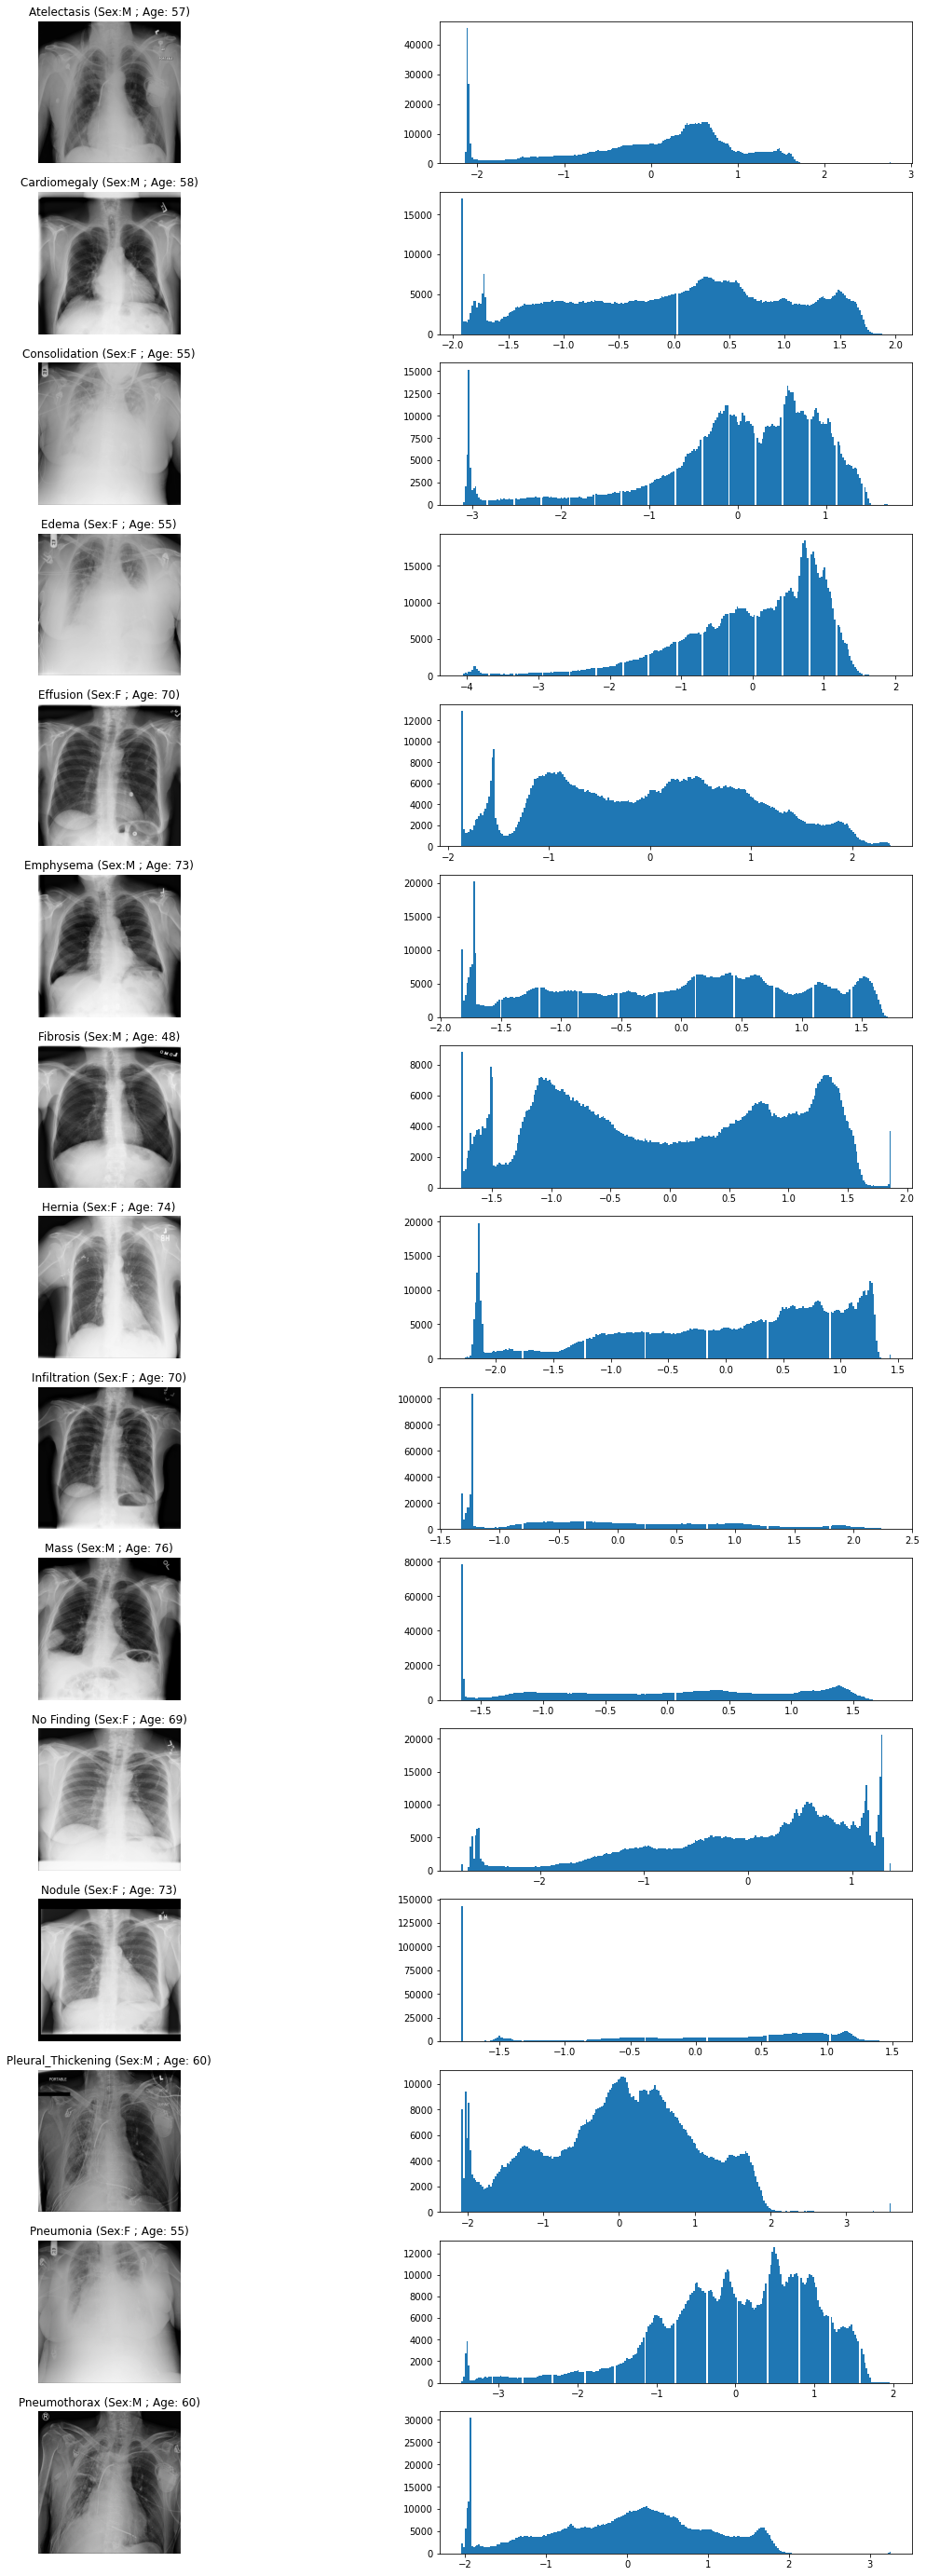

In [180]:
fig, ax = plt.subplots(len(all_labels), 2, figsize = (20, 50))

for iteration,disease_name in enumerate(all_labels):
    image_name =  img_analysis_df[img_analysis_df[disease_name]==1]['Image Index'].reset_index(drop=True)[1]
    patient_gender =  img_analysis_df[img_analysis_df[disease_name]==1]['Patient Gender'].reset_index(drop=True)[1]
    patient_age =  img_analysis_df[img_analysis_df[disease_name]==1]['Patient Age'].reset_index(drop=True)[1]
    view_position = img_analysis_df[img_analysis_df[disease_name]==1]['View Position'].reset_index(drop=True)[1]
    rel_path = "/data/images_001/images/"
    image_path = rel_path + image_name
    if os.path.exists(image_path):
        read_image =  plt.imread(image_path)
        ax[iteration, 0].imshow(read_image, cmap = 'gray')
        image_title = disease_name + " (Sex:" + patient_gender + " ; Age: " + str(patient_age) + ")"
        mean_intensity = np.mean(read_image)
#         print(mean_intensity)
        std_intensity = np.std(read_image)
        std_intensity
        new_img = read_image.copy()
        new_img = (new_img - mean_intensity)/std_intensity
        ax[iteration, 1].hist(new_img.ravel(), bins = 256) 
        ax[iteration, 0].set_title(image_title)
        ax[iteration, 0].axis('off')
        

# Overall Conclusion Pointers
1. Amongst all the 15 unique disease labels, 'No Finding' label had the maximum number of records in the dataset.
2. Age is normally distributed by looking at the Histogram Plot
3. Removed 16 records containing Outliers (i.e.,) Age greater than 100
4. Male Population were highly infected with Pneuomia than Female population based on the analysis of the given NIH dataset
5. As concluded in the Correlation Matrix Conclusion section, with the bar plot, it can be seen that the diseases that are closely occurring to Pneumonia are Edema and Infiltration
6. Requires Image Data Augmentation since the image data exclusively for Pneumonia labelled data is uneven (Imbalance in the dataset)
7. The model could be deceived by the combination of the following disease labels: Pneumonia, Edema and Infiltration. This is because the intensity values are similar